In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

image_size = 50 # image size in pixels
sigma = 5.4 / (2 * np.sqrt(2 * np.log(2))) # FWHM = 5.4

In [ ]:
def find_correlation_matrix(image_size,sigma):
    """
    - Inputs:
        - image_size: data dimensionality
        - sigma: standard deviation of the target distribution.
    - Outputs:
        - Correlation matrix: the corrlation matrix as specified in the algorithm in the markdown cells above.
    """
    x, y = np.meshgrid(np.arange(image_size), np.arange(image_size), indexing="ij")
    pixel_coords = np.stack((x.ravel(), y.ravel()), axis=1)
    i, j = pixel_coords[:, 0], pixel_coords[:, 1] 

    di = i[:, None] - i[None, :] # Difference in x for all coordinates
    dj = j[:, None] - j[None, :] # Difference in y for all coordinats
    d = 1.8*np.sqrt(di**2 + dj**2) # d[x,x'] difference in euclidean distance between the two pixels in the (RA,\delta) ~ Euclidean R^{22500 \otimes 22500}

    C= (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-d**2 / (2 * sigma**2)) # Just the N(0,sigma^2)

    # Set the diagonal elements to 1
    np.fill_diagonal(C, 1)

    return C

The aim of this notebook is to write working code that does two things:
1. Try and find a sparse, and good approximation of the covariance (correlation) matrix.
2. Try to implement the multivariate sampling for the matrix, and $(Ra,\delta)$ and then repeat (1)

### Sparse-ifying $\Sigma$

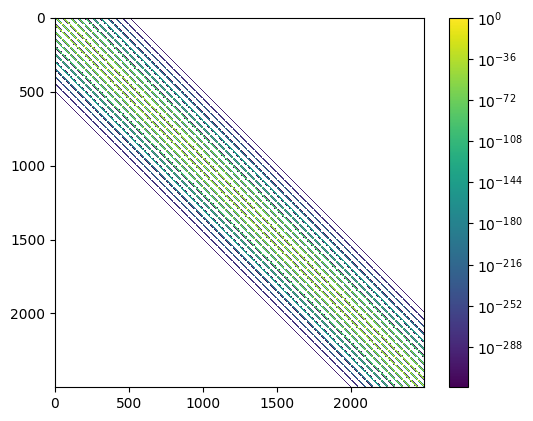

In [3]:
covariance_matrix = find_correlation_matrix(image_size,sigma)

# Plot the covariance matrix
plt.imshow(covariance_matrix, cmap='viridis', interpolation='nearest',norm=LogNorm())
plt.colorbar()
plt.show()

The values very steeply fall off well past computational accuracy. It is likely we can very easily find a sparse representation by determining a point where the values are too small.

In [14]:
C = find_correlation_matrix(image_size,sigma)
x, y = np.meshgrid(np.arange(image_size), np.arange(image_size), indexing="ij")
pixel_coords = np.stack((x.ravel(), y.ravel()), axis=1)
i, j = pixel_coords[:, 0], pixel_coords[:, 1]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(C, ax=ax[0], cbar=True, norm=LogNorm(vmin=C[C > 0].min(), vmax=C.max()))
sns.heatmap(d, ax=ax[1], cmap='viridis', cbar=True)

ax[0].set_title('Covariance Matrix')
ax[1].set_title('Distance Matrix')

# Remove tick labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# Thresholds for boundaries
thresholds = [1e-6, 1e-12]
distances_from_diagonal = {}

for threshold in thresholds:
    indices = np.where(C < threshold)
    
    for idx1, idx2 in zip(indices[0], indices[1]):
        if idx1 < idx2:  # Avoid duplicate lines
            x1, y1 = pixel_coords[idx1]
            x2, y2 = pixel_coords[idx2]
            
            # Draw the boundary lines
            ax[0].plot([y1, y2], [x1, x2], color='red' if threshold == 1e-6 else 'blue', linewidth=1.5)

            # Compute distance from diagonal
            distance = np.abs(idx1 - idx2)
            if threshold not in distances_from_diagonal:
                distances_from_diagonal[threshold] = []
            distances_from_diagonal[threshold].append(distance)

# Print distances from diagonal
for threshold, distances in distances_from_diagonal.items():
    print(f"Threshold {threshold}: Mean Distance from Diagonal = {np.mean(distances):.2f}")

plt.show()
